In [1]:
%load_ext autoreload
%autoreload 2

# Analysis of sequence-level mutations

For DPhil thesis.

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import partial

from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from common import set_theme

set_theme(style='whitegrid')
PALETTE = 'viridis'

top_write_dir = os.path.join('data', '25_mutations')

In [3]:
fn = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
data = pd.read_csv(fn)

In [4]:
data.rename(columns={'mutation_num': 'N mutations'}, inplace=True)
data['Log sensitivity'] = np.log10(data['sensitivity'])
data['Log precision'] = np.log10(data['precision'])
data['adaptation'] = calculate_adaptation(np.array(data['sensitivity']), np.array(data['precision']), alpha=2)


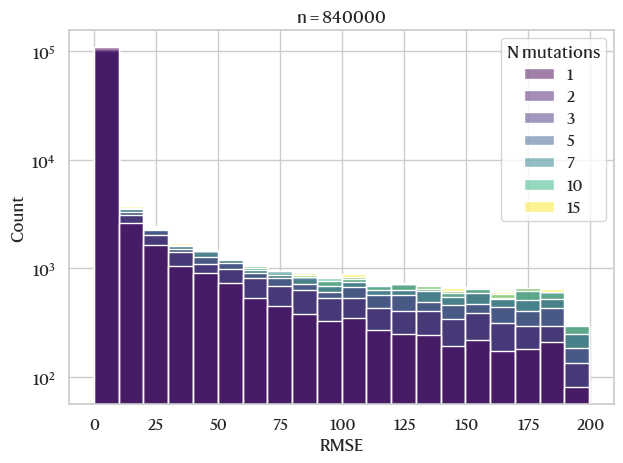

In [5]:
filt_samp = (data['sample_name'] == 'RNA_2')
filt_m = (data['N mutations'] > 0)
filt = filt_m & filt_samp & (
    data['RMSE'].notnull()) & (data['RMSE'] < np.inf)
g = sns.histplot(data[filt], x='RMSE', hue='N mutations',
             palette=PALETTE,
             bins=20) #, fill=False, element='step')
plt.yscale('log')
plt.title(f'n = {len(data[filt])}')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutation_rmse_histogram.png'), dpi=300, transparent=True)

In [6]:
get_true_interaction_cols2 = partial(get_true_interaction_cols, remove_symmetrical=True, num_species=data['sample_name'].nunique())

datam = pd.DataFrame()
k = 'energies'
cols_e = get_true_interaction_cols2(data, k)
datam[f'{k}_diffs'] = data[filt_samp].groupby(['circuit_name'])[cols_e].apply(
    lambda x: x - x.iloc[0]).melt(value_vars=cols_e, 
                                  var_name='idx', value_name=f'{k}_diffs')[f'{k}_diffs']
datam[['idx', 'N mutations']] = data[filt_samp].melt(id_vars = 'N mutations',value_vars=cols_e, 
                                  var_name='idx', value_name=f'{k}_diffs')[['idx', 'N mutations']]

In [7]:
for k in ['Log sensitivity', 'Log precision', 'adaptation']:
    # data[f'{k} diffs'] = data.groupby(['circuit_name', 'sample_name'])[k].apply(lambda x: x - x.iloc[0]).reset_index()[k]
    data[f'{k} diffs'] = data.groupby(['circuit_name', 'sample_name'])[k].apply(lambda x: x - x.iloc[0]).reset_index().sort_values('level_2').reset_index()[k]

In [8]:
data.head()

,circuit_name,mutation_name,N mutations,mutation_type,mutation_positions,path_to_template_circuit,index,sample_num,name,interacting,...,response_time,precision,sensitivity,sample_name,Log sensitivity,Log precision,adaptation,Log sensitivity diffs,Log precision diffs,adaptation diffs
0,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[[0 1]],...,1.002004,1.110351,1.000000,RNA_0,0.000000,0.045460,846.429810,0.000000,0.000000,0.00000
1,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[[0 1]],...,1.002004,10.266712,0.097402,RNA_1,-1.011431,1.011431,829.532410,0.000000,0.000000,0.00000
2,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[[0 1]],...,inf,4182.322300,0.000239,RNA_2,-3.621418,3.621417,759.327637,0.000000,0.000000,0.00000
3,toy_mRNA_circuit_0,RNA_0_m1-0,1,[3],[18],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[[0 1]],...,3.006012,1.218610,1.000000,RNA_0,0.000000,0.085865,847.030640,0.000000,0.040405,0.60083
4,toy_mRNA_circuit_0,RNA_0_m1-0,1,[3],[18],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[[0 1]],...,4.008016,5.625166,0.177773,RNA_1,-0.750135,0.750135,834.310120,0.261296,-0.261296,4.77771


n = 5000 reference circuits


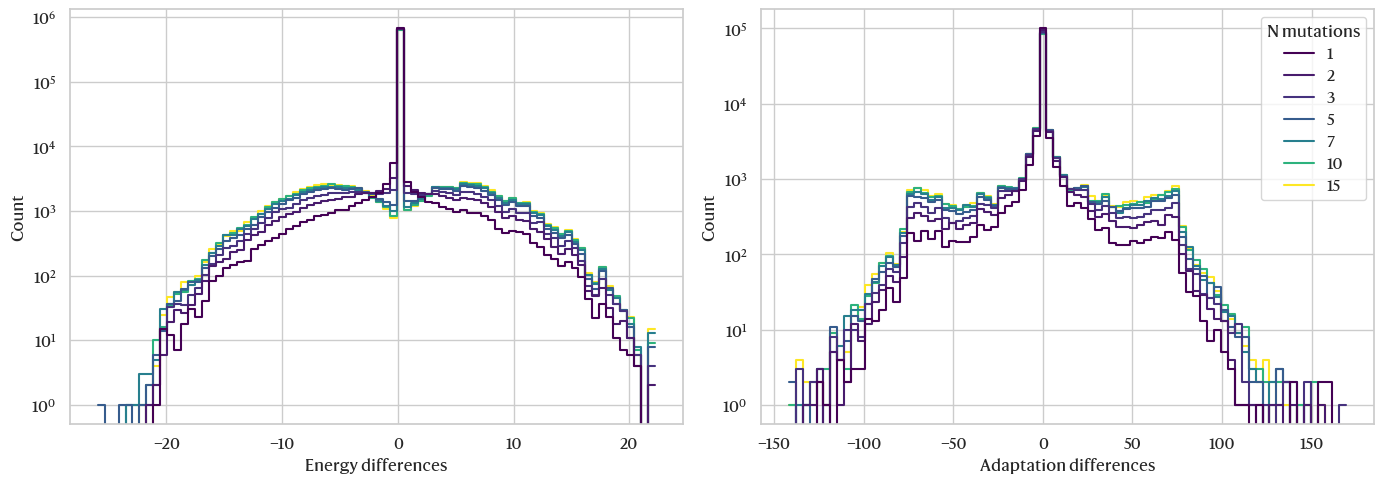

In [9]:
# plt.figure(figsize=(7,5))
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(datam[datam['N mutations'] > 0], x=f'energies_diffs', hue='N mutations',
             palette=PALETTE, bins=80, fill=False, element='step', ax=axs[0], legend=False)
axs[0].set_xlabel('Energy differences')
axs[0].set_yscale('log')

g = sns.histplot(data[filt_m & filt_samp], x=f'adaptation diffs', hue='N mutations',
                 # sns.histplot(data[filt_m & filt_samp], x=f'Log sensitivity diffs', hue='N mutations',
                 palette=PALETTE, bins=80, fill=False, element='step', ax=axs[1])
sns.move_legend(axs[1], "upper right",
                bbox_to_anchor=(1, 1), title='N mutations')
axs[1].set_xlabel('Adaptation differences')
axs[1].set_yscale('log')

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutation_energy_adaptation_diffs_histogram.png'),
            dpi=300, transparent=True, bbox_inches='tight')

print(f'n = {data["circuit_name"].nunique()} reference circuits')

Energy differences may be different for self-interactions vs. cross-interactions

In [10]:
# for k in cols_e:
#     data[k + '_diffs'] = data.groupby(['circuit_name', 'sample_name'])[k].apply(
#         lambda x: x - x.iloc[0]).reset_index().set_index('level_2').sort_index()[k]
# data.iloc[:1000].groupby(['circuit_name', 'sample_name'])[k].apply(
#     lambda x: x - x.iloc[0]).reset_index().set_index('level_2').sort_index()[k]
# data.drop(columns=[k + '_diffs' for k in cols_e], inplace=True, errors='ignore')

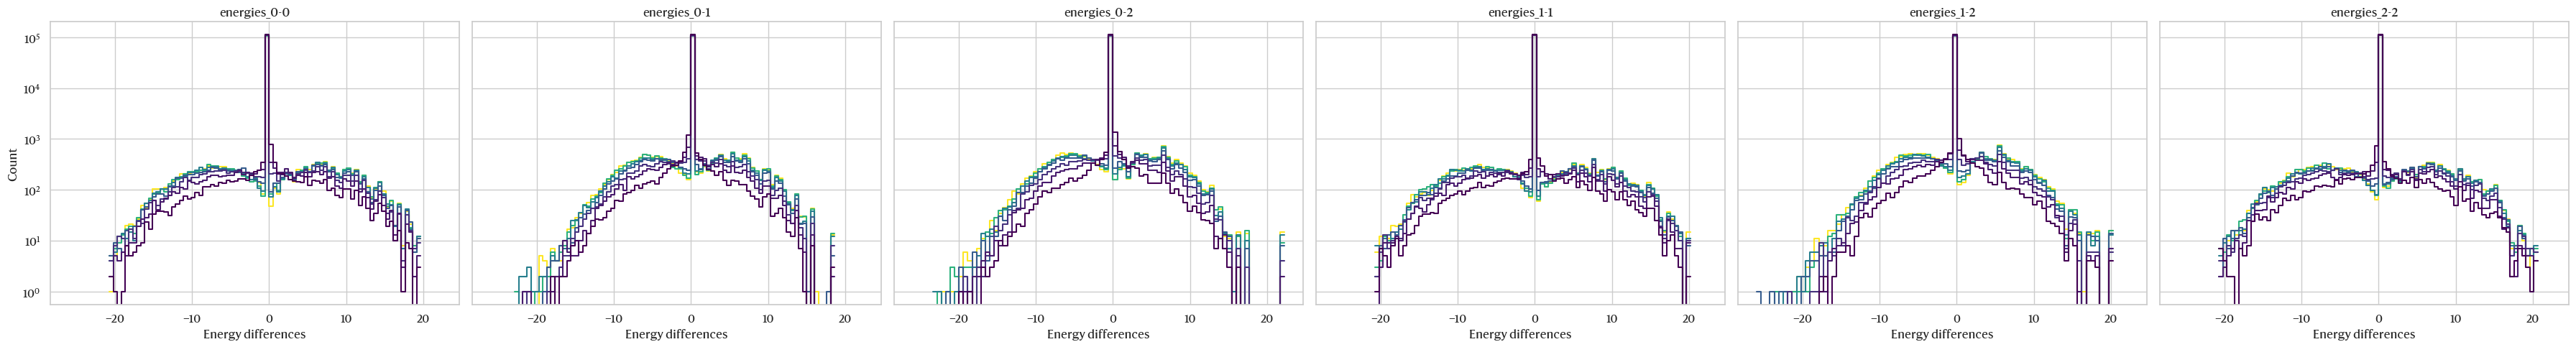

In [11]:
n_cols = len(cols_e)
fig, axs = plt.subplots(1, n_cols, figsize=(6 * n_cols, 5), sharey=True, sharex=True)

for i, k in enumerate(cols_e):
    filt = (datam['idx'] == k) & (datam['N mutations'] > 0)
    sns.histplot(datam[filt], x=f'energies_diffs', hue='N mutations',
                palette=PALETTE, bins=80, fill=False, element='step', ax=axs[i], legend=False)
    axs[i].set_xlabel('Energy differences')
    axs[i].set_yscale('log')
    axs[i].set_title(k)
    
plt.tight_layout()
    

In [12]:
cols_e_self = [k for k in cols_e if k.split('_')[1].split('-')[0] == k.split('_')[1].split('-')[1]]
cols_e_diff = [k for k in cols_e if k not in cols_e_self]

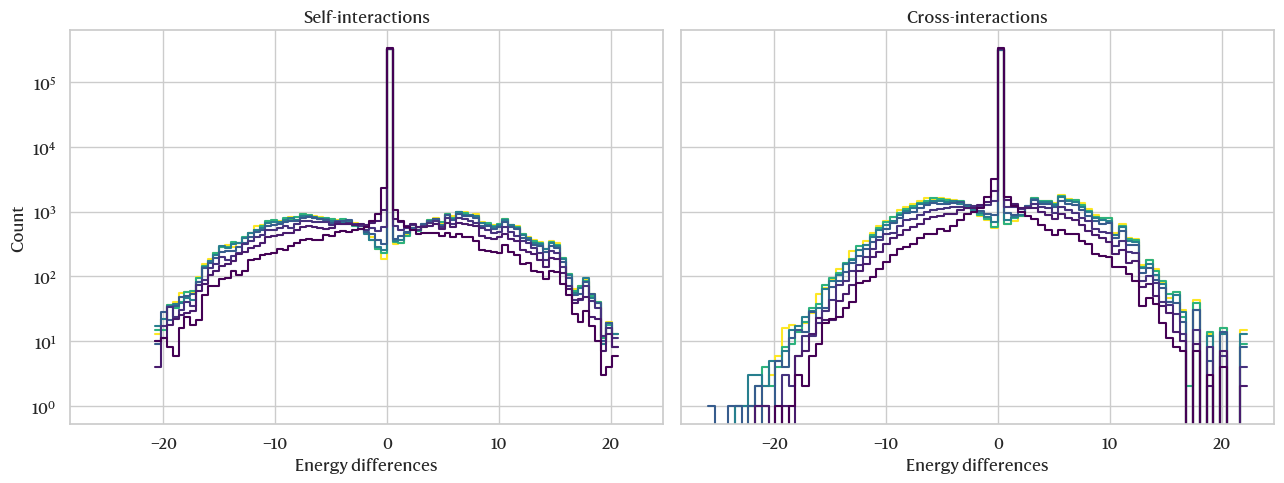

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5), sharex=True, sharey=True)
filt_same = datam['idx'].isin(cols_e_self) & (datam['N mutations'] > 0)
sns.histplot(datam[filt_same], x=f'energies_diffs', hue='N mutations',
             palette=PALETTE, bins=80, fill=False, element='step', ax=axs[0], legend=False)
axs[0].set_xlabel('Energy differences')
axs[0].set_yscale('log')
axs[0].set_title('Self-interactions')

filt_diff = datam['idx'].isin(cols_e_diff) & (datam['N mutations'] > 0)
sns.histplot(datam[filt_diff], x=f'energies_diffs', hue='N mutations',
             palette=PALETTE, bins=80, fill=False, element='step', ax=axs[1], legend=False)
axs[1].set_xlabel('Energy differences')
axs[1].set_yscale('log')
axs[1].set_title('Cross-interactions')

plt.tight_layout()
# plt.savefig(os.path.join(top_write_dir, 'mutation_energy_adaptation_diffs_histogram.png'),
#             dpi=300, transparent=True, bbox_inches='tight')

# Mutation type and position

In [ ]:
import ast

data['mutation_type_list'] = data['mutation_type'].apply(ast.literal_eval)
data['mutation_positions_list'] = data['mutation_positions'].apply(ast.literal_eval)


In [ ]:
cols = ['mutation_type_list', 'mutation_positions_list', 'N mutations', 'circuit_name', 'mutation_name',
        'adaptation diffs', 'Log sensitivity diffs', 'Log precision diffs', 
        'adaptation', 'sensitivity', 'precision', 'Log sensitivity', 'Log precision']
df_mutations = data[filt_samp][cols].explode('mutation_type_list').reset_index()
df_mutations['mutation_positions_list'] = data[filt_samp & filt_m][cols].explode('mutation_positions_list').reset_index()['mutation_positions_list']

In [ ]:
from synbio_morpher.utils.evolution.mutation import get_mutation_type_mapping


def reverse_mut_mapping_custom(mut_encoding: int, sequence_type: str = 'RNA'):
    for k, v in get_mutation_type_mapping(sequence_type).items():
        if mut_encoding in list(v.values()):
            for mut, enc in v.items():
                if enc == mut_encoding:
                    return f'{k}->{mut}'
    raise ValueError(
        f'Could not find mutation for mapping key {mut_encoding}.')
    
    
mut_flatmap = {i: reverse_mut_mapping_custom(i, 'RNA')
               for i in sorted(df_mutations['mutation_type_list'].unique()) if np.isnan(i) == False}

df_mutations['Mutation Type'] = df_mutations['mutation_type_list'].apply(
    lambda x: mut_flatmap[x] if np.isnan(x) == False else 'NA')


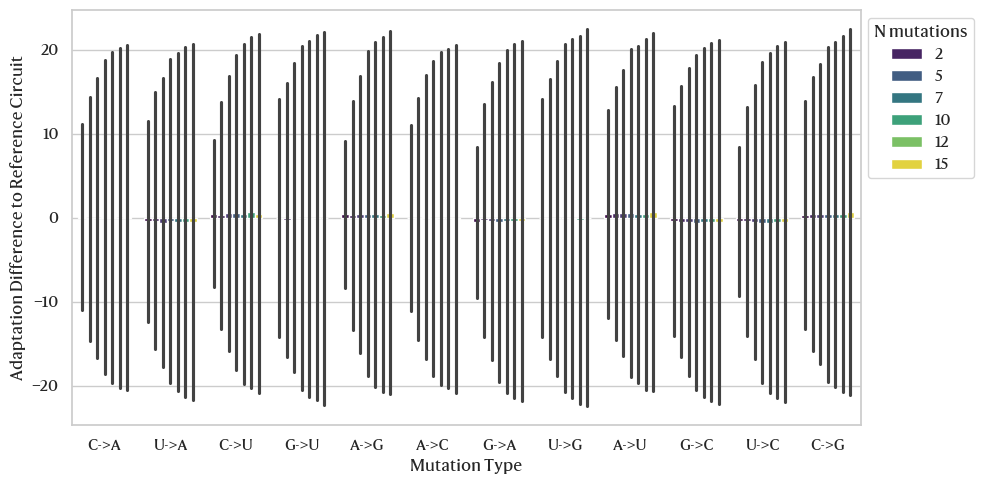

In [ ]:
plt.figure(figsize=(10, 5))
g = sns.barplot(df_mutations[df_mutations['N mutations'] > 0],
                x='Mutation Type', y='adaptation diffs',
                hue='N mutations',
                palette=PALETTE, errorbar='sd')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel('Adaptation Difference to Reference Circuit')
# plt.xlabel('Mutation Type')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutation_type_adaptation_diffs.png'),
            dpi=300, bbox_inches='tight', transparent=True)

# Mutation position

In [ ]:
df_mutations[(df_mutations['N mutations'] == 0) & (df_mutations['Log sensitivity'] > 0)]

,index,mutation_type_list,mutation_positions_list,N mutations,circuit_name,mutation_name,adaptation diffs,Log sensitivity diffs,Log precision diffs,adaptation,sensitivity,precision,Log sensitivity,Log precision,Mutation Type


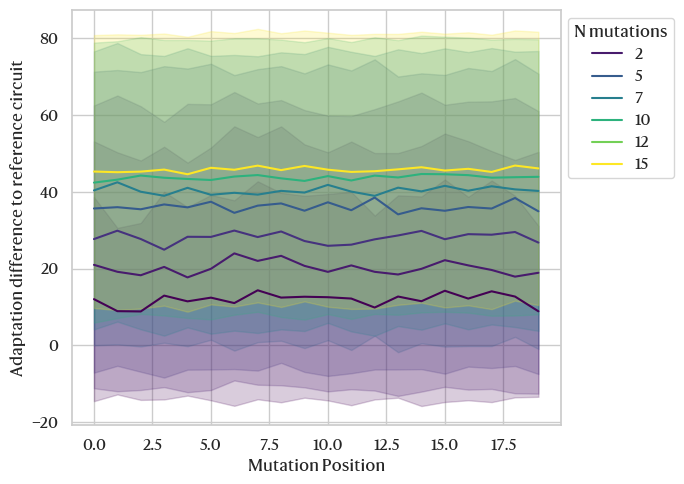

In [ ]:
plt.figure(figsize=(7, 5))
g = sns.lineplot(df_mutations[(df_mutations['Log sensitivity'] >= -1) & (df_mutations['Log precision'] >= 0)
                              & (df_mutations['N mutations'] > 0)],
                 x='mutation_positions_list', y='adaptation diffs',
                 hue='N mutations',
                 palette=PALETTE, errorbar='sd')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Mutation Position')
plt.ylabel('Adaptation difference to reference circuit')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutation_position_adaptation_diffs.png'),
            dpi=300, bbox_inches='tight', transparent=True)

# Plot the adaptation by circuit index, with the number of mutations as the hue

This was not super informative

In [ ]:
# # data['circuit_idx'] = 
# data['circuit_idx'] = 0
# for s in data['sample_name'].unique():
#     d = dict(data[(data['N mutations'] == 0) & (data['sample_name'] == s)].sort_values('adaptation').reset_index(
#         ).rename(columns={'level_0': 'idx'}).reset_index()[['circuit_name', 'level_0']].values.tolist()) #.reset_index().groupby('circuit_name').ngroup()
#     data.loc[data['sample_name'] == s, 'circuit_idx'] = data[data['sample_name'] == s]['circuit_name'].apply(lambda x: d[x])

<Axes: xlabel='circuit_idx', ylabel='adaptation'>

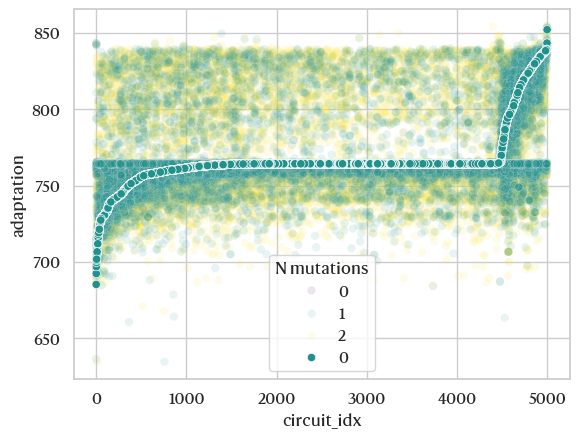

In [ ]:
# sns.scatterplot(data[(data['sample_name'] == 'RNA_2') & (data['N mutations'] < 3)].sort_values('N mutations', ascending=False),
#                 x='circuit_idx', y='adaptation', hue='N mutations', palette=PALETTE, alpha=0.1)
# sns.scatterplot(data[(data['sample_name'] == 'RNA_2') & (data['N mutations'] == 0)].sort_values('N mutations', ascending=False),
#                 x='circuit_idx', y='adaptation', hue='N mutations', palette=PALETTE)